In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CALM_Implementation.ipynb

"""
# Continuous Autoregressive Language Models (CALM) - Complete Implementation
## Based on the paper: "Continuous Autoregressive Language Models"

This notebook implements the complete CALM framework for efficient language generation.
Optimized for Google Colab with adjustable parameters for different computational budgets.
"""

In [2]:
!pip install torch transformers datasets accelerate wandb -q --upgrade
!pip install einops rotary_embedding_torch -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 674.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 153.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:
!pip uninstall torch

In [4]:
# !pip install torch==2.5.1

In [5]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [6]:
import torch
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"PyTorch CUDA version: {torch.version.cuda}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

Is CUDA available? True
PyTorch CUDA version: 12.1
Device name: Tesla T4


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import math
import random
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path

# For tokenization
from transformers import AutoTokenizer

# Fix for wandb compatibility issues
!pip install --upgrade --force-reinstall wandb protobuf -q

# For logging (optional)
# import wandb

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.4/463.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.4/402.4 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [35]:
# # Cell 2: Configuration
# @dataclass
# class AutoencoderConfig:
#     """Configuration for the robust autoencoder"""
#     vocab_size: int = 32000
#     chunk_size: int = 4  # K in the paper
#     hidden_dim: int = 512
#     latent_dim: int = 128
#     num_layers: int = 2
#     dropout_rate: float = 0.15
#     kl_weight: float = 0.001
#     kl_clip: float = 0.5

# @dataclass
# class CALMConfig:
#     """Configuration for the CALM model"""
#     vocab_size: int = 32000
#     hidden_dim: int = 768
#     num_layers: int = 12
#     num_heads: int = 12
#     ff_dim: int = 2048
#     max_seq_length: int = 512  # in vectors, not tokens
#     chunk_size: int = 4
#     latent_dim: int = 128
#     noise_dim: int = 256
#     num_gen_blocks: int = 3  # L/4 in paper
#     dropout: float = 0.1

# @dataclass
# class TrainingConfig:
#     """Training configuration"""
#     # Autoencoder training
#     ae_batch_size: int = 128
#     ae_learning_rate: float = 3e-4
#     ae_num_steps: int = 10000  # Reduced for Colab

#     # CALM training
#     calm_batch_size: int = 32
#     calm_learning_rate: float = 3e-4
#     calm_num_steps: int = 25000  # Reduced for Colab

#     # Energy loss params
#     num_model_samples: int = 8  # N in paper
#     num_target_samples: int = 100  # M in paper

#     # General
#     gradient_clip: float = 1.0
#     warmup_steps: int = 500
#     save_every: int = 1000
#     eval_every: int = 500

#     # Paths
#     checkpoint_dir: str = "/content/checkpoints"
#     data_dir: str = "/content/data"

In [36]:
@dataclass
class AutoencoderConfig:
    """Configuration for the robust autoencoder"""
    vocab_size: int = 50257  # GPT2's actual vocab size
    chunk_size: int = 4  # K in the paper
    hidden_dim: int = 768  # Changed from 512 to match CALMConfig.hidden_dim
    latent_dim: int = 128
    num_layers: int = 2
    dropout_rate: float = 0.15
    kl_weight: float = 0.001
    kl_clip: float = 0.5

@dataclass
class CALMConfig:
    """Configuration for the CALM model"""
    vocab_size: int = 50257  # GPT2's actual vocab size
    hidden_dim: int = 768
    num_layers: int = 12
    num_heads: int = 12
    ff_dim: int = 2048
    max_seq_length: int = 512  # in vectors, not tokens
    chunk_size: int = 4
    latent_dim: int = 128
    noise_dim: int = 256
    num_gen_blocks: int = 3  # L/4 in paper
    dropout: float = 0.1

@dataclass
class TrainingConfig:
    """Training configuration"""
    # Autoencoder training
    ae_batch_size: int = 64  # Reduced for memory
    ae_learning_rate: float = 3e-4
    ae_num_steps: int = 5000  # Further reduced for testing

    # CALM training
    calm_batch_size: int = 16  # Reduced for memory
    calm_learning_rate: float = 3e-4
    calm_num_steps: int = 10000  # Reduced for testing

    # Energy loss params
    num_model_samples: int = 8  # N in paper
    num_target_samples: int = 50  # Reduced M for memory

    # General
    gradient_clip: float = 1.0
    warmup_steps: int = 500
    save_every: int = 1000
    eval_every: int = 500

    # Paths
    checkpoint_dir: str = "/content/checkpoints"
    data_dir: str = "/content/data"

# Fixed Cell 9: Data Loading with tokenizer vocab size
class TextDataset(Dataset):
    """Simple text dataset for training"""

    def __init__(self, texts: List[str], tokenizer, max_length: int, chunk_size: int):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.chunk_size = chunk_size

        # Ensure max_length is divisible by chunk_size
        self.padded_length = ((max_length // chunk_size)) * chunk_size
        if self.padded_length == 0:
            self.padded_length = chunk_size

        # Tokenize all texts with consistent length
        self.encoded_texts = []
        for text in texts:
            # Tokenize
            encoded = tokenizer.encode(
                text,
                max_length=self.padded_length,
                truncation=True,
                add_special_tokens=True
            )

            # Convert to tensor
            encoded = torch.tensor(encoded, dtype=torch.long)

            if len(encoded) < self.padded_length:
                # Pad if needed
                padding = torch.full(
                    (self.padded_length - len(encoded),),
                    tokenizer.pad_token_id,
                    dtype=torch.long
                )
                encoded = torch.cat([encoded, padding])
            elif len(encoded) > self.padded_length:
                # Truncate if needed
                encoded = encoded[:self.padded_length]

            self.encoded_texts.append(encoded)

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        return self.encoded_texts[idx]

def create_dummy_data(num_samples: int = 500, seq_length: int = 128):
    """Create dummy training data for testing"""
    # Use GPT2 tokenizer
    from transformers import GPT2Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'right'

    print(f"Tokenizer vocab size: {tokenizer.vocab_size}")

    # Generate dummy texts
    texts = []
    templates = [
        "The quick brown fox jumps over the lazy dog. ",
        "In a hole in the ground there lived a hobbit. ",
        "To be or not to be, that is the question. ",
        "All happy families are alike; each unhappy family is unhappy in its own way. ",
        "It was the best of times, it was the worst of times. ",
        "Once upon a time in a land far away, there was a kingdom. ",
        "The sun rose over the mountains, casting long shadows. ",
        "She walked through the garden, admiring the flowers. "
    ]

    for _ in range(num_samples):
        # Randomly combine templates
        num_templates = random.randint(2, 4)
        text = ""
        for _ in range(num_templates):
            text += random.choice(templates)
        texts.append(text)

    return texts, tokenizer

# Updated Main function with better error handling
def main():
    """Main training pipeline"""

    # Initialize configurations
    ae_config = AutoencoderConfig()
    calm_config = CALMConfig()
    train_config = TrainingConfig()

    # Create dummy data
    print("Creating training data...")
    texts, tokenizer = create_dummy_data(num_samples=500, seq_length=128)

    # Update configs with actual vocab size
    actual_vocab_size = tokenizer.vocab_size
    ae_config.vocab_size = actual_vocab_size
    calm_config.vocab_size = actual_vocab_size
    print(f"Using vocabulary size: {actual_vocab_size}")

    # Create dataset with consistent padding
    dataset = TextDataset(
        texts,
        tokenizer,
        max_length=128,
        chunk_size=ae_config.chunk_size
    )

    # Verify all sequences have the same length
    print(f"Dataset size: {len(dataset)}")
    print(f"Sequence length: {dataset[0].shape}")
    print(f"Max token value in dataset: {max([t.max().item() for t in dataset.encoded_texts[:10]])}")
    print(f"Min token value in dataset: {min([t.min().item() for t in dataset.encoded_texts[:10]])}")

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=train_config.ae_batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn
    )

    # Test dataloader
    test_batch = next(iter(dataloader))
    print(f"Batch shape: {test_batch.shape}")
    print(f"Batch dtype: {test_batch.dtype}")
    print(f"Max value in batch: {test_batch.max().item()}")

    # Phase 1: Train Autoencoder
    print("\n" + "="*50)
    print("Phase 1: Training Robust Autoencoder")
    print("="*50)

    autoencoder = RobustAutoencoder(ae_config)
    print(f"Autoencoder embedding size: {autoencoder.token_embeddings.weight.shape}")

    ae_losses, ae_accuracies = train_autoencoder(
        autoencoder,
        dataloader,
        train_config,
        device
    )

    # Plot autoencoder training curves
    if len(ae_losses) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot(ae_losses)
        ax1.set_title('Autoencoder Loss')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')

        ax2.plot(ae_accuracies)
        ax2.set_title('Reconstruction Accuracy')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('Accuracy')
        plt.tight_layout()
        plt.show()

    # Verify autoencoder quality
    autoencoder.eval()
    with torch.no_grad():
        test_batch = next(iter(dataloader)).to(device)
        test_chunk = test_batch[:, :ae_config.chunk_size]
        outputs = autoencoder(test_chunk)
        print(f"\nAutoencoder Final Accuracy: {outputs['accuracy'].item():.4f}")
        print(f"KL Loss: {outputs['kl_loss'].item():.4f}")

    # Phase 2: Train CALM Model
    print("\n" + "="*50)
    print("Phase 2: Training CALM Model")
    print("="*50)

    # Update dataloader for CALM training with smaller batch size
    calm_dataloader = DataLoader(
        dataset,
        batch_size=train_config.calm_batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn
    )

    # Initialize CALM model
    calm_model = CALMModel(calm_config, autoencoder)
    print(f"CALM model initialized with {sum(p.numel() for p in calm_model.parameters() if p.requires_grad)} trainable parameters")

    # Train CALM
    calm_losses = train_calm(
        calm_model,
        calm_dataloader,
        train_config,
        device
    )

    # Plot CALM training curve
    if len(calm_losses) > 0:
        plt.figure(figsize=(8, 4))
        plt.plot(calm_losses)
        plt.title('CALM Energy Loss')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.show()

    # Phase 3: Generation Demo
    print("\n" + "="*50)
    print("Phase 3: Text Generation Demo")
    print("="*50)

    calm_model.eval()
    with torch.no_grad():
        # Prepare prompt
        prompt_text = "The quick brown fox"
        prompt_ids = tokenizer.encode(prompt_text)

        # Pad to chunk size
        remainder = len(prompt_ids) % calm_config.chunk_size
        if remainder != 0:
            prompt_ids = prompt_ids + [tokenizer.pad_token_id] * (calm_config.chunk_size - remainder)

        prompt_tensor = torch.tensor([prompt_ids], dtype=torch.long).to(device)

        # Generate
        print(f"\nPrompt: {prompt_text}")
        print("Generating...")

        try:
            generated = calm_model.generate(
                prompt_tensor,
                max_new_vectors=10,
                temperature=0.8,
                num_samples=5
            )

            # Decode
            generated_text = tokenizer.decode(generated[0].cpu().tolist(), skip_special_tokens=True)
            print(f"Generated: {generated_text}")
        except Exception as e:
            print(f"Generation failed: {e}")

    print("\n" + "="*50)
    print("Training Complete!")
    print("="*50)

    return autoencoder, calm_model

In [37]:
# # Cell 3: Robust Variational Autoencoder
# class RobustAutoencoder(nn.Module):
#     """
#     Implements the robust autoencoder with:
#     - Variational regularization with KL clipping
#     - Dropout on latent and input
#     - High-fidelity reconstruction (>99.9% accuracy)
#     """

#     def __init__(self, config: AutoencoderConfig):
#         super().__init__()
#         self.config = config

#         # Encoder components
#         self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_dim)

#         # Position-wise FFN for each token
#         self.encoder_token_ffn = nn.Sequential(
#             nn.Linear(config.hidden_dim, config.hidden_dim * 2),
#             nn.ReLU(),
#             nn.Dropout(config.dropout_rate),
#             nn.Linear(config.hidden_dim * 2, config.hidden_dim)
#         )

#         # Compression layers
#         self.encoder_compress = nn.Linear(
#             config.chunk_size * config.hidden_dim,
#             config.hidden_dim
#         )

#         self.encoder_ffn = nn.Sequential(
#             nn.Linear(config.hidden_dim, config.hidden_dim * 2),
#             nn.ReLU(),
#             nn.Dropout(config.dropout_rate),
#             nn.Linear(config.hidden_dim * 2, config.hidden_dim)
#         )

#         # Variational head - outputs mean and log variance
#         self.to_mu = nn.Linear(config.hidden_dim, config.latent_dim)
#         self.to_logvar = nn.Linear(config.hidden_dim, config.latent_dim)

#         # Decoder components (mirror of encoder)
#         self.decoder_initial = nn.Linear(config.latent_dim, config.hidden_dim)

#         self.decoder_ffn = nn.Sequential(
#             nn.Linear(config.hidden_dim, config.hidden_dim * 2),
#             nn.ReLU(),
#             nn.Dropout(config.dropout_rate),
#             nn.Linear(config.hidden_dim * 2, config.hidden_dim)
#         )

#         self.decoder_expand = nn.Linear(
#             config.hidden_dim,
#             config.chunk_size * config.hidden_dim
#         )

#         self.decoder_token_ffn = nn.Sequential(
#             nn.Linear(config.hidden_dim, config.hidden_dim * 2),
#             nn.ReLU(),
#             nn.Dropout(config.dropout_rate),
#             nn.Linear(config.hidden_dim * 2, config.hidden_dim)
#         )

#         # Output projection (tied with input embeddings)
#         self.output_projection = nn.Linear(
#             config.hidden_dim,
#             config.vocab_size,
#             bias=False
#         )
#         self.output_projection.weight = self.token_embeddings.weight

#         # Dropout layers
#         self.latent_dropout = nn.Dropout(config.dropout_rate)

#     def encode(self, input_ids: torch.Tensor, mask_tokens: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
#         """
#         Encode tokens to latent distribution
#         Args:
#             input_ids: [batch, chunk_size]
#             mask_tokens: whether to apply input token masking (training only)
#         Returns:
#             z: sampled latent vector [batch, latent_dim]
#             mu: mean [batch, latent_dim]
#             logvar: log variance [batch, latent_dim]
#         """
#         batch_size, chunk_size = input_ids.shape

#         # Apply token masking if training
#         if mask_tokens and self.training:
#             mask = torch.bernoulli(torch.full_like(input_ids, 1 - self.config.dropout_rate, dtype=torch.float))
#             # Use a special mask token (could be 0 or a designated token)
#             input_ids = input_ids * mask.long()

#         # Embed tokens
#         x = self.token_embeddings(input_ids)  # [batch, chunk_size, hidden_dim]

#         # Position-wise FFN
#         x = x + self.encoder_token_ffn(x)  # [batch, chunk_size, hidden_dim]

#         # Flatten and compress
#         x = x.view(batch_size, -1)  # [batch, chunk_size * hidden_dim]
#         x = self.encoder_compress(x)  # [batch, hidden_dim]
#         x = self.encoder_ffn(x)  # [batch, hidden_dim]

#         # Get distribution parameters
#         mu = self.to_mu(x)  # [batch, latent_dim]
#         logvar = self.to_logvar(x)  # [batch, latent_dim]

#         # Sample using reparameterization trick
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         z = mu + eps * std

#         return z, mu, logvar

#     def decode(self, z: torch.Tensor) -> torch.Tensor:
#         """
#         Decode latent vector to token logits
#         Args:
#             z: latent vector [batch, latent_dim]
#         Returns:
#             logits: [batch, chunk_size, vocab_size]
#         """
#         batch_size = z.shape[0]

#         # Apply dropout to latent (training only)
#         if self.training:
#             z = self.latent_dropout(z)

#         # Initial projection
#         x = self.decoder_initial(z)  # [batch, hidden_dim]
#         x = self.decoder_ffn(x)  # [batch, hidden_dim]

#         # Expand
#         x = self.decoder_expand(x)  # [batch, chunk_size * hidden_dim]
#         x = x.view(batch_size, self.config.chunk_size, self.config.hidden_dim)

#         # Position-wise FFN
#         x = x + self.decoder_token_ffn(x)  # [batch, chunk_size, hidden_dim]

#         # Project to vocabulary
#         logits = self.output_projection(x)  # [batch, chunk_size, vocab_size]

#         return logits

#     def forward(self, input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
#         """
#         Full forward pass with loss computation
#         """
#         # Encode
#         z, mu, logvar = self.encode(input_ids, mask_tokens=True)

#         # Decode
#         logits = self.decode(z)

#         # Compute losses
#         # Reconstruction loss
#         recon_loss = F.cross_entropy(
#             logits.view(-1, self.config.vocab_size),
#             input_ids.view(-1),
#             reduction='mean'
#         )

#         # KL divergence with clipping
#         kl_loss = self.compute_kl_loss(mu, logvar)

#         # Total loss
#         total_loss = recon_loss + self.config.kl_weight * kl_loss

#         # Compute accuracy for monitoring
#         predictions = torch.argmax(logits, dim=-1)
#         accuracy = (predictions == input_ids).float().mean()

#         return {
#             'loss': total_loss,
#             'recon_loss': recon_loss,
#             'kl_loss': kl_loss,
#             'accuracy': accuracy,
#             'logits': logits,
#             'z': z,
#             'mu': mu,
#             'logvar': logvar
#         }

#     def compute_kl_loss(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
#         """
#         Compute KL divergence with per-dimension clipping
#         """
#         # KL divergence for each dimension
#         kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())

#         # Apply clipping threshold
#         kl_per_dim = torch.clamp(kl_per_dim, min=self.config.kl_clip)

#         # Average over batch and dimensions
#         kl_loss = kl_per_dim.mean()

#         return kl_loss

In [38]:
# Fixed Cell 3: Robust Variational Autoencoder with reshape fixes
class RobustAutoencoder(nn.Module):
    """
    Implements the robust autoencoder with:
    - Variational regularization with KL clipping
    - Dropout on latent and input
    - High-fidelity reconstruction (>99.9% accuracy)
    """

    def __init__(self, config: AutoencoderConfig):
        super().__init__()
        self.config = config

        # Encoder components
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_dim)

        # Position-wise FFN for each token
        self.encoder_token_ffn = nn.Sequential(
            nn.Linear(config.hidden_dim, config.hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim * 2, config.hidden_dim)
        )

        # Compression layers
        self.encoder_compress = nn.Linear(
            config.chunk_size * config.hidden_dim,
            config.hidden_dim
        )

        self.encoder_ffn = nn.Sequential(
            nn.Linear(config.hidden_dim, config.hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim * 2, config.hidden_dim)
        )

        # Variational head - outputs mean and log variance
        self.to_mu = nn.Linear(config.hidden_dim, config.latent_dim)
        self.to_logvar = nn.Linear(config.hidden_dim, config.latent_dim)

        # Decoder components (mirror of encoder)
        self.decoder_initial = nn.Linear(config.latent_dim, config.hidden_dim)

        self.decoder_ffn = nn.Sequential(
            nn.Linear(config.hidden_dim, config.hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim * 2, config.hidden_dim)
        )

        self.decoder_expand = nn.Linear(
            config.hidden_dim,
            config.chunk_size * config.hidden_dim
        )

        self.decoder_token_ffn = nn.Sequential(
            nn.Linear(config.hidden_dim, config.hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(config.dropout_rate),
            nn.Linear(config.hidden_dim * 2, config.hidden_dim)
        )

        # Output projection (tied with input embeddings)
        self.output_projection = nn.Linear(
            config.hidden_dim,
            config.vocab_size,
            bias=False
        )
        self.output_projection.weight = self.token_embeddings.weight

        # Dropout layers
        self.latent_dropout = nn.Dropout(config.dropout_rate)

    def encode(self, input_ids: torch.Tensor, mask_tokens: bool = False) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Encode tokens to latent distribution
        Args:
            input_ids: [batch, chunk_size]
            mask_tokens: whether to apply input token masking (training only)
        Returns:
            z: sampled latent vector [batch, latent_dim]
            mu: mean [batch, latent_dim]
            logvar: log variance [batch, latent_dim]
        """
        batch_size, chunk_size = input_ids.shape

        # Apply token masking if training
        if mask_tokens and self.training:
            mask = torch.bernoulli(torch.full_like(input_ids, 1 - self.config.dropout_rate, dtype=torch.float))
            # Use a special mask token (could be 0 or a designated token)
            input_ids = input_ids * mask.long()

        # Embed tokens
        x = self.token_embeddings(input_ids)  # [batch, chunk_size, hidden_dim]

        # Position-wise FFN
        x = x + self.encoder_token_ffn(x)  # [batch, chunk_size, hidden_dim]

        # Flatten and compress - use reshape instead of view
        x = x.reshape(batch_size, -1)  # [batch, chunk_size * hidden_dim]
        x = self.encoder_compress(x)  # [batch, hidden_dim]
        x = self.encoder_ffn(x)  # [batch, hidden_dim]

        # Get distribution parameters
        mu = self.to_mu(x)  # [batch, latent_dim]
        logvar = self.to_logvar(x)  # [batch, latent_dim]

        # Sample using reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        return z, mu, logvar

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode latent vector to token logits
        Args:
            z: latent vector [batch, latent_dim]
        Returns:
            logits: [batch, chunk_size, vocab_size]
        """
        batch_size = z.shape[0]

        # Apply dropout to latent (training only)
        if self.training:
            z = self.latent_dropout(z)

        # Initial projection
        x = self.decoder_initial(z)  # [batch, hidden_dim]
        x = self.decoder_ffn(x)  # [batch, hidden_dim]

        # Expand
        x = self.decoder_expand(x)  # [batch, chunk_size * hidden_dim]
        x = x.reshape(batch_size, self.config.chunk_size, self.config.hidden_dim)

        # Position-wise FFN
        x = x + self.decoder_token_ffn(x)  # [batch, chunk_size, hidden_dim]

        # Project to vocabulary
        logits = self.output_projection(x)  # [batch, chunk_size, vocab_size]

        return logits

    def forward(self, input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Full forward pass with loss computation
        """
        # Ensure input is contiguous
        input_ids = input_ids.contiguous()

        # Encode
        z, mu, logvar = self.encode(input_ids, mask_tokens=True)

        # Decode
        logits = self.decode(z)

        # Compute losses - use reshape instead of view
        # Reconstruction loss
        recon_loss = F.cross_entropy(
            logits.reshape(-1, self.config.vocab_size),
            input_ids.reshape(-1),
            reduction='mean'
        )

        # KL divergence with clipping
        kl_loss = self.compute_kl_loss(mu, logvar)

        # Total loss
        total_loss = recon_loss + self.config.kl_weight * kl_loss

        # Compute accuracy for monitoring
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == input_ids).float().mean()

        return {
            'loss': total_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss,
            'accuracy': accuracy,
            'logits': logits,
            'z': z,
            'mu': mu,
            'logvar': logvar
        }

    def compute_kl_loss(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Compute KL divergence with per-dimension clipping
        """
        # KL divergence for each dimension
        kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())

        # Apply clipping threshold
        kl_per_dim = torch.clamp(kl_per_dim, min=self.config.kl_clip)

        # Average over batch and dimensions
        kl_loss = kl_per_dim.mean()

        return kl_loss

In [39]:
# Cell 4: Energy-Based Generative Head
class EnergyGenerativeHead(nn.Module):
    """
    Energy-based generative head for single-step continuous generation
    """

    def __init__(self, hidden_dim: int, latent_dim: int, noise_dim: int, num_blocks: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.noise_dim = noise_dim
        self.num_blocks = num_blocks

        # Initial projections
        self.hidden_proj = nn.Linear(hidden_dim, hidden_dim)
        self.noise_proj = nn.Linear(noise_dim, hidden_dim)

        # Residual MLP blocks
        self.blocks = nn.ModuleList([
            ResidualMLPBlock(hidden_dim) for _ in range(num_blocks)
        ])

        # Final projection to latent space
        self.output_proj = nn.Linear(hidden_dim, latent_dim)

    def forward(self, hidden_state: torch.Tensor, num_samples: int = 1) -> torch.Tensor:
        """
        Generate samples from the energy-based model
        Args:
            hidden_state: [batch, hidden_dim]
            num_samples: number of samples to generate per input
        Returns:
            samples: [batch, num_samples, latent_dim]
        """
        batch_size = hidden_state.shape[0]

        # Generate random noise
        noise = torch.rand(batch_size, num_samples, self.noise_dim, device=hidden_state.device) - 0.5

        # Expand hidden state for multiple samples
        h = hidden_state.unsqueeze(1).expand(-1, num_samples, -1)
        h = h.reshape(batch_size * num_samples, self.hidden_dim)

        # Project inputs
        h_proj = self.hidden_proj(h)
        noise_flat = noise.reshape(batch_size * num_samples, self.noise_dim)
        noise_proj = self.noise_proj(noise_flat)

        # Initial combination
        x = h_proj + noise_proj

        # Pass through residual blocks
        for block in self.blocks:
            x = block(x, h_proj)

        # Final projection
        output = self.output_proj(x)

        # Reshape to separate samples
        output = output.reshape(batch_size, num_samples, self.latent_dim)

        return output

class ResidualMLPBlock(nn.Module):
    """
    Residual MLP block with SwiGLU activation
    """

    def __init__(self, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Linear layers for combining with hidden state
        self.h_linear = nn.Linear(hidden_dim, hidden_dim)
        self.x_linear = nn.Linear(hidden_dim, hidden_dim)

        # SwiGLU components
        self.w1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.w2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.w3 = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with residual connection
        """
        # Combine with hidden state
        combined = self.h_linear(h) + self.x_linear(x)

        # SwiGLU
        gate = F.silu(self.w1(combined))
        value = self.w2(combined)
        output = self.w3(gate * value)

        # Residual connection
        return x + output

In [40]:
class RMSNorm(nn.Module):
    """RMSNorm normalization layer"""

    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * norm * self.weight

class RotaryPositionalEncoding(nn.Module):
    """Rotary Positional Encoding (RoPE)"""

    def __init__(self, dim: int, max_seq_len: int = 2048, base: float = 10000):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        self.base = base

        # Precompute frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

        # Precompute position indices
        pos = torch.arange(max_seq_len)
        freqs = torch.einsum('i,j->ij', pos, self.inv_freq)

        self.register_buffer('cos_cached', torch.cos(freqs))
        self.register_buffer('sin_cached', torch.sin(freqs))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply rotary positional encoding"""
        # x shape: (B, num_heads, T, head_dim)
        # We need seq_len = T (at index 2)
        seq_len = x.shape[2] # Corrected from x.shape[1]

        # Get precomputed cos and sin, slice to current seq_len
        # cos_cached shape: [max_seq_len, dim/2]
        # After slicing: [seq_len, dim/2]
        cos = self.cos_cached[:seq_len].to(x.dtype)
        sin = self.sin_cached[:seq_len].to(x.dtype)

        # Unsqueeze cos and sin to (1, 1, seq_len, dim/2) for broadcasting
        # This matches x1, x2 which are (B, num_heads, seq_len, dim/2)
        cos = cos.unsqueeze(0).unsqueeze(0) # -> (1, 1, T, head_dim/2)
        sin = sin.unsqueeze(0).unsqueeze(0) # -> (1, 1, T, head_dim/2)

        # Apply rotation
        x1 = x[..., ::2] # (B, num_heads, T, head_dim/2)
        x2 = x[..., 1::2] # (B, num_heads, T, head_dim/2)

        # Rotate
        rotated_x1 = x1 * cos - x2 * sin
        rotated_x2 = x1 * sin + x2 * cos

        # Combine
        out = torch.stack([rotated_x1, rotated_x2], dim=-1).flatten(-2)

        return out

class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention with RoPE"""

    def __init__(self, config: CALMConfig):
        super().__init__()
        assert config.hidden_dim % config.num_heads == 0

        self.num_heads = config.num_heads
        self.head_dim = config.hidden_dim // config.num_heads
        self.hidden_dim = config.hidden_dim

        self.qkv = nn.Linear(config.hidden_dim, 3 * config.hidden_dim)
        self.out_proj = nn.Linear(config.hidden_dim, config.hidden_dim)

        self.rope = RotaryPositionalEncoding(self.head_dim, config.max_seq_length)
        self.dropout = nn.Dropout(config.dropout)

        # Causal mask
        mask = torch.tril(torch.ones(config.max_seq_length, config.max_seq_length))
        self.register_buffer('mask', mask.view(1, 1, config.max_seq_length, config.max_seq_length))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape

        # Get Q, K, V
        qkv = self.qkv(x)
        q, k, v = qkv.split(self.hidden_dim, dim=2)

        # Reshape for multi-head attention
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        # Apply RoPE
        q = self.rope(q)
        k = self.rope(k)

        # Attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        scores = scores.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply attention to values
        out = torch.matmul(attn_weights, v)

        # Reshape back
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.out_proj(out)
        out = self.dropout(out)

        return out

class SwiGLUFeedForward(nn.Module):
    """SwiGLU feed-forward network"""

    def __init__(self, config: CALMConfig):
        super().__init__()
        self.w1 = nn.Linear(config.hidden_dim, config.ff_dim)
        self.w2 = nn.Linear(config.hidden_dim, config.ff_dim)
        self.w3 = nn.Linear(config.ff_dim, config.hidden_dim)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate = F.silu(self.w1(x))
        value = self.w2(x)
        out = self.w3(gate * value)
        return self.dropout(out)

class TransformerBlock(nn.Module):
    """Transformer block with RMSNorm and SwiGLU"""

    def __init__(self, config: CALMConfig):
        super().__init__()
        self.attn_norm = RMSNorm(config.hidden_dim)
        self.attn = CausalSelfAttention(config)
        self.ffn_norm = RMSNorm(config.hidden_dim)
        self.ffn = SwiGLUFeedForward(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.attn_norm(x))
        x = x + self.ffn(self.ffn_norm(x))
        return x

class InputCompressionMLP(nn.Module):
    """Compress K token embeddings into single representation"""

    def __init__(self, chunk_size: int, hidden_dim: int):
        super().__init__()
        self.chunk_size = chunk_size
        self.hidden_dim = hidden_dim

        self.mlp = nn.Sequential(
            nn.Linear(chunk_size * hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [batch, chunk_size, hidden_dim]
        Returns:
            compressed: [batch, hidden_dim]
        """
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.mlp(x)

class CALMModel(nn.Module):
    """
    Complete CALM model with:
    - Transformer backbone
    - Energy-based generative head
    - Discrete token input processing
    """

    def __init__(self, config: CALMConfig, autoencoder: RobustAutoencoder):
        super().__init__()
        self.config = config
        self.autoencoder = autoencoder

        # Freeze autoencoder
        for param in self.autoencoder.parameters():
            param.requires_grad = False

        # Token embeddings (shared with autoencoder)
        self.token_embeddings = self.autoencoder.token_embeddings

        # Input compression
        self.input_compression = InputCompressionMLP(config.chunk_size, config.hidden_dim)

        # Transformer backbone
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config) for _ in range(config.num_layers)
        ])

        self.ln_f = RMSNorm(config.hidden_dim)

        # Energy-based generative head
        self.generative_head = EnergyGenerativeHead(
            config.hidden_dim,
            config.latent_dim,
            config.noise_dim,
            config.num_gen_blocks
        )

    def forward(self, input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward pass for training
        Args:
            input_ids: [batch, seq_len * chunk_size] full sequence tokens
        Returns:
            dict with predictions and targets for energy loss
        """
        batch_size = input_ids.shape[0]
        total_tokens = input_ids.shape[1]
        chunk_size = self.config.chunk_size
        seq_len = total_tokens // chunk_size

        # Reshape to chunks
        input_chunks = input_ids.view(batch_size, seq_len, chunk_size)

        # Encode all chunks with frozen autoencoder to get targets
        target_vectors = []
        target_mus = []
        target_logvars = []

        with torch.no_grad():
            for i in range(seq_len):
                z, mu, logvar = self.autoencoder.encode(input_chunks[:, i])
                target_vectors.append(z)
                target_mus.append(mu)
                target_logvars.append(logvar)

        target_vectors = torch.stack(target_vectors, dim=1)  # [batch, seq_len, latent_dim]
        target_mus = torch.stack(target_mus, dim=1)
        target_logvars = torch.stack(target_logvars, dim=1)

        # Process sequence autoregressively
        hidden_states = []

        for i in range(seq_len - 1):  # -1 because we predict next
            # Get current chunk tokens
            curr_tokens = input_chunks[:, i]  # [batch, chunk_size]

            # Embed and compress
            token_embeds = self.token_embeddings(curr_tokens)  # [batch, chunk_size, hidden_dim]
            compressed = self.input_compression(token_embeds)  # [batch, hidden_dim]

            # Add to sequence
            if i == 0:
                h = compressed.unsqueeze(1)  # [batch, 1, hidden_dim]
            else:
                h = torch.cat([h, compressed.unsqueeze(1)], dim=1)

            # Pass through transformer blocks
            for block in self.transformer_blocks:
                h = block(h)

            # Store final hidden state for this position
            hidden_states.append(self.ln_f(h[:, -1]))  # [batch, hidden_dim]

        hidden_states = torch.stack(hidden_states, dim=1)  # [batch, seq_len-1, hidden_dim]

        return {
            'hidden_states': hidden_states,
            'target_vectors': target_vectors[:, 1:],  # Next vectors as targets
            'target_mus': target_mus[:, 1:],
            'target_logvars': target_logvars[:, 1:]
        }

    @torch.no_grad()
    def generate(self,
                 prompt_ids: torch.Tensor,
                 max_new_vectors: int = 50,
                 temperature: float = 1.0,
                 num_samples: int = 1) -> torch.Tensor:
        """
        Generate new tokens autoregressively
        Args:
            prompt_ids: [batch, prompt_length] initial tokens
            max_new_vectors: number of vectors to generate (each = chunk_size tokens)
            temperature: sampling temperature (implemented via batch size)
            num_samples: number of samples for selection
        Returns:
            generated token ids
        """
        batch_size = prompt_ids.shape[0]
        chunk_size = self.config.chunk_size
        device = prompt_ids.device

        # Process prompt
        prompt_len = prompt_ids.shape[1]
        num_chunks = prompt_len // chunk_size

        # Initialize with prompt chunks
        generated_tokens = prompt_ids.clone()

        # Build initial hidden states from prompt
        h = None
        for i in range(num_chunks):
            chunk = prompt_ids[:, i*chunk_size:(i+1)*chunk_size]
            token_embeds = self.token_embeddings(chunk)
            compressed = self.input_compression(token_embeds)

            if h is None:
                h = compressed.unsqueeze(1)
            else:
                h = torch.cat([h, compressed.unsqueeze(1)], dim=1)

            # Pass through transformer
            for block in self.transformer_blocks:
                h = block(h)

        # Generate new vectors
        for _ in range(max_new_vectors):
            # Get last hidden state
            last_hidden = self.ln_f(h[:, -1])  # [batch, hidden_dim]

            # Generate multiple samples from generative head
            z_samples = self.generative_head(last_hidden, num_samples)  # [batch, num_samples, latent_dim]

            # For simplicity, take the first sample (could implement temperature sampling here)
            z = z_samples[:, 0]  # [batch, latent_dim]

            # Decode to tokens
            with torch.no_grad():
                logits = self.autoencoder.decode(z)  # [batch, chunk_size, vocab_size]
                tokens = torch.argmax(logits, dim=-1)  # [batch, chunk_size]

            # Append to generated sequence
            generated_tokens = torch.cat([generated_tokens, tokens], dim=1)

            # Update hidden states for next iteration
            token_embeds = self.token_embeddings(tokens)
            compressed = self.input_compression(token_embeds)
            h = torch.cat([h, compressed.unsqueeze(1)], dim=1)

            # Limit context length
            if h.shape[1] > self.config.max_seq_length:
                h = h[:, -self.config.max_seq_length:]

            # Pass through transformer
            for block in self.transformer_blocks:
                h = block(h)

        return generated_tokens

In [41]:
# Cell 6: Energy Loss Implementation
def compute_energy_loss(predictions: torch.Tensor,
                        target_mus: torch.Tensor,
                        target_logvars: torch.Tensor,
                        num_target_samples: int = 100,
                        alpha: float = 1.0) -> torch.Tensor:
    """
    Compute the energy loss for training CALM
    Args:
        predictions: [batch, seq_len, num_model_samples, latent_dim]
        target_mus: [batch, seq_len, latent_dim]
        target_logvars: [batch, seq_len, latent_dim]
        num_target_samples: M in the paper
        alpha: exponent for distance (1.0 for L1 distance)
    Returns:
        energy loss scalar
    """
    batch_size, seq_len, num_model_samples, latent_dim = predictions.shape

    # Sample targets from the posterior distribution
    target_samples = []
    for _ in range(num_target_samples):
        std = torch.exp(0.5 * target_logvars)
        eps = torch.randn_like(std)
        z = target_mus + eps * std
        target_samples.append(z)

    target_samples = torch.stack(target_samples, dim=2)  # [batch, seq_len, M, latent_dim]

    # Compute fidelity term: distance between predictions and targets
    # Expand dimensions for broadcasting
    pred_expanded = predictions.unsqueeze(3)  # [batch, seq_len, N, 1, latent_dim]
    target_expanded = target_samples.unsqueeze(2)  # [batch, seq_len, 1, M, latent_dim]

    if alpha == 1.0:
        distances = torch.abs(pred_expanded - target_expanded).sum(-1)  # L1 distance
    else:
        distances = torch.pow(torch.abs(pred_expanded - target_expanded).sum(-1), alpha)

    fidelity = distances.mean()  # Average over all pairs

    # Compute diversity term: distance between prediction pairs
    pred1 = predictions.unsqueeze(3)  # [batch, seq_len, N, 1, latent_dim]
    pred2 = predictions.unsqueeze(2)  # [batch, seq_len, 1, N, latent_dim]

    if alpha == 1.0:
        pred_distances = torch.abs(pred1 - pred2).sum(-1)  # [batch, seq_len, N, N]
    else:
        pred_distances = torch.pow(torch.abs(pred1 - pred2).sum(-1), alpha)

    # Mask diagonal (distance to self)
    mask = torch.eye(num_model_samples, device=predictions.device).bool()
    pred_distances = pred_distances.masked_fill(mask, 0)

    # Sum over non-diagonal elements
    diversity = pred_distances.sum(dim=(2, 3)) / (num_model_samples * (num_model_samples - 1))
    diversity = diversity.mean()

    # Energy loss
    energy_loss = 2 * fidelity - diversity

    return energy_loss



In [42]:
# Cell 7: BrierLM Metric
class BrierLMMetric:
    """
    Implements BrierLM evaluation metric for likelihood-free language modeling
    """

    def __init__(self, max_n: int = 4):
        self.max_n = max_n

    def compute_brier_n(self,
                       sample1: torch.Tensor,
                       sample2: torch.Tensor,
                       target: torch.Tensor,
                       n: int) -> float:
        """
        Compute Brier-n score for n-gram evaluation
        Args:
            sample1, sample2: [seq_len] generated samples
            target: [seq_len] ground truth
            n: n-gram length
        """
        seq_len = len(target)
        if seq_len < n:
            return 0.0

        scores = []
        for i in range(seq_len - n + 1):
            # Get n-grams
            ngram1 = tuple(sample1[i:i+n].tolist())
            ngram2 = tuple(sample2[i:i+n].tolist())
            ngram_target = tuple(target[i:i+n].tolist())

            # Compute matches
            match1 = int(ngram1 == ngram_target)
            match2 = int(ngram2 == ngram_target)
            collision = int(ngram1 == ngram2)

            # Brier score for this n-gram
            score = match1 + match2 - collision
            scores.append(score)

        return np.mean(scores) if scores else 0.0

    def compute(self, model: CALMModel, input_ids: torch.Tensor) -> Dict[str, float]:
        """
        Compute BrierLM score
        Args:
            model: CALM model
            input_ids: [batch, seq_len * chunk_size]
        Returns:
            dict with Brier-n scores and BrierLM
        """
        model.eval()
        results = {}

        with torch.no_grad():
            # Generate two samples
            # This is simplified - in practice you'd generate properly
            output = model(input_ids)
            hidden_states = output['hidden_states']

            # Generate samples from hidden states
            batch_size, seq_len, _ = hidden_states.shape
            samples1 = []
            samples2 = []

            for i in range(seq_len):
                h = hidden_states[:, i]
                z_samples = model.generative_head(h, num_samples=2)

                # Decode to tokens
                logits1 = model.autoencoder.decode(z_samples[:, 0])
                logits2 = model.autoencoder.decode(z_samples[:, 1])

                tokens1 = torch.argmax(logits1, dim=-1)
                tokens2 = torch.argmax(logits2, dim=-1)

                samples1.append(tokens1)
                samples2.append(tokens2)

            # Compute Brier scores
            for n in range(1, self.max_n + 1):
                # Simplified - compute for first sequence in batch
                sample1_flat = torch.cat(samples1, dim=-1)[0].cpu()
                sample2_flat = torch.cat(samples2, dim=-1)[0].cpu()
                target_flat = input_ids[0, model.config.chunk_size:].cpu()

                brier_n = self.compute_brier_n(sample1_flat, sample2_flat, target_flat, n)
                results[f'brier_{n}'] = brier_n

            # Geometric mean for BrierLM
            scores = [results[f'brier_{n}'] for n in range(1, self.max_n + 1)]
            brierlm = 100 * (np.prod(scores) ** (1 / len(scores)))
            results['brierlm'] = brierlm

        return results



In [43]:
# Cell 8: Temperature Sampling (Batch Approximation)
class TemperatureSampler:
    """
    Implements likelihood-free temperature sampling via batch approximation
    """

    @staticmethod
    def sample_with_temperature(samples: torch.Tensor,
                               temperature: float,
                               batch_size: int = 500) -> torch.Tensor:
        """
        Sample with temperature from batch of samples
        Args:
            samples: [batch, num_samples, ...] generated samples
            temperature: T = 1/n where n is integer
            batch_size: size of batch for approximation
        Returns:
            selected samples
        """
        if temperature >= 1.0:
            # Random sampling for T >= 1
            indices = torch.randint(0, samples.shape[1], (samples.shape[0],))
            return samples[torch.arange(samples.shape[0]), indices]

        n = int(1 / temperature)
        batch_size = min(batch_size, samples.shape[1])

        # Count occurrences in batch
        selected = []
        for b in range(samples.shape[0]):
            batch_samples = samples[b, :batch_size]

            # Find unique samples and counts
            unique_samples, inverse, counts = torch.unique(
                batch_samples.view(batch_size, -1),
                dim=0,
                return_inverse=True,
                return_counts=True
            )

            # Compute weights (binomial coefficients)
            weights = []
            valid_indices = []

            for idx, count in enumerate(counts):
                if count >= n:
                    # Compute C(count, n)
                    weight = math.comb(int(count), n)
                    weights.append(weight)
                    valid_indices.append(idx)

            if not weights:
                # Fallback: reduce n requirement
                for fallback_n in range(n-1, 0, -1):
                    for idx, count in enumerate(counts):
                        if count >= fallback_n:
                            weight = math.comb(int(count), fallback_n)
                            weights.append(weight)
                            valid_indices.append(idx)
                    if weights:
                        break

            if weights:
                # Sample according to weights
                weights = torch.tensor(weights, dtype=torch.float)
                probs = weights / weights.sum()
                idx = torch.multinomial(probs, 1)[0]
                selected_idx = valid_indices[idx]

                # Find first occurrence of selected unique sample
                selected_sample_idx = (inverse == selected_idx).nonzero()[0, 0]
                selected.append(batch_samples[selected_sample_idx])
            else:
                # Ultimate fallback: random selection
                selected.append(batch_samples[0])

        return torch.stack(selected)

In [44]:
# # Cell 9: Data Loading
# class TextDataset(Dataset):
#     """Simple text dataset for training"""

#     def __init__(self, texts: List[str], tokenizer, max_length: int, chunk_size: int):
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.chunk_size = chunk_size

#         # Tokenize all texts
#         self.encoded_texts = []
#         for text in texts:
#             encoded = tokenizer.encode(text, max_length=max_length, truncation=True)
#             # Pad to multiple of chunk_size
#             remainder = len(encoded) % chunk_size
#             if remainder != 0:
#                 encoded = encoded + [tokenizer.pad_token_id] * (chunk_size - remainder)
#             self.encoded_texts.append(torch.tensor(encoded))

#     def __len__(self):
#         return len(self.encoded_texts)

#     def __getitem__(self, idx):
#         return self.encoded_texts[idx]

# def create_dummy_data(num_samples: int = 1000, seq_length: int = 128):
#     """Create dummy training data for testing"""
#     # Use a simple tokenizer
#     from transformers import GPT2Tokenizer
#     tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
#     tokenizer.pad_token = tokenizer.eos_token

#     # Generate dummy texts
#     texts = []
#     templates = [
#         "The quick brown fox jumps over the lazy dog. ",
#         "In a hole in the ground there lived a hobbit. ",
#         "To be or not to be, that is the question. ",
#         "All happy families are alike; each unhappy family is unhappy in its own way. ",
#         "It was the best of times, it was the worst of times. "
#     ]

#     for _ in range(num_samples):
#         # Randomly combine templates
#         num_templates = random.randint(1, 5)
#         text = ""
#         for _ in range(num_templates):
#             text += random.choice(templates)
#         texts.append(text)

#     return texts, tokenizer

In [45]:
# Fixed Cell 9: Data Loading with proper padding
class TextDataset(Dataset):
    """Simple text dataset for training"""

    def __init__(self, texts: List[str], tokenizer, max_length: int, chunk_size: int):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.chunk_size = chunk_size

        # Ensure max_length is divisible by chunk_size
        self.padded_length = ((max_length // chunk_size) + 1) * chunk_size

        # Tokenize all texts with consistent length
        self.encoded_texts = []
        for text in texts:
            # Tokenize
            encoded = tokenizer.encode(
                text,
                max_length=self.padded_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )

            # Ensure it's exactly padded_length
            if isinstance(encoded, torch.Tensor):
                encoded = encoded.squeeze()
            else:
                encoded = torch.tensor(encoded)

            if len(encoded) < self.padded_length:
                # Pad if needed
                padding = torch.full(
                    (self.padded_length - len(encoded),),
                    tokenizer.pad_token_id
                )
                encoded = torch.cat([encoded, padding])
            elif len(encoded) > self.padded_length:
                # Truncate if needed
                encoded = encoded[:self.padded_length]

            self.encoded_texts.append(encoded)

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        return self.encoded_texts[idx]

def create_dummy_data(num_samples: int = 1000, seq_length: int = 128):
    """Create dummy training data for testing"""
    # Use a simple tokenizer
    from transformers import GPT2Tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'right'  # Ensure right padding

    # Generate dummy texts
    texts = []
    templates = [
        "The quick brown fox jumps over the lazy dog. ",
        "In a hole in the ground there lived a hobbit. ",
        "To be or not to be, that is the question. ",
        "All happy families are alike; each unhappy family is unhappy in its own way. ",
        "It was the best of times, it was the worst of times. "
    ]

    for _ in range(num_samples):
        # Randomly combine templates
        num_templates = random.randint(1, 5)
        text = ""
        for _ in range(num_templates):
            text += random.choice(templates)
        texts.append(text)

    return texts, tokenizer

# Also fix the collate function for the dataloader
def collate_fn(batch):
    """Custom collate function to handle batching"""
    # Stack all tensors (they should all be the same size now)
    return torch.stack(batch, dim=0)

# Updated Cell 11: Main Training Pipeline with fixed dataloader
def main():
    """Main training pipeline"""

    # Initialize configurations
    ae_config = AutoencoderConfig()
    calm_config = CALMConfig()
    train_config = TrainingConfig()

    # Create dummy data
    print("Creating training data...")
    texts, tokenizer = create_dummy_data(num_samples=1000, seq_length=128)

    # Create dataset with consistent padding
    dataset = TextDataset(
        texts,
        tokenizer,
        max_length=128,
        chunk_size=ae_config.chunk_size
    )

    # Verify all sequences have the same length
    print(f"Dataset size: {len(dataset)}")
    print(f"Sequence length: {dataset[0].shape}")

    # Create dataloader with custom collate function
    dataloader = DataLoader(
        dataset,
        batch_size=train_config.ae_batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn  # Add custom collate function
    )

    # Test dataloader
    test_batch = next(iter(dataloader))
    print(f"Batch shape: {test_batch.shape}")

    # Phase 1: Train Autoencoder
    print("\n" + "="*50)
    print("Phase 1: Training Robust Autoencoder")
    print("="*50)

    autoencoder = RobustAutoencoder(ae_config)
    ae_losses, ae_accuracies = train_autoencoder(
        autoencoder,
        dataloader,
        train_config,
        device
    )

    # Plot autoencoder training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(ae_losses)
    ax1.set_title('Autoencoder Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')

    ax2.plot(ae_accuracies)
    ax2.set_title('Reconstruction Accuracy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    # Verify autoencoder quality
    autoencoder.eval()
    with torch.no_grad():
        test_batch = next(iter(dataloader)).to(device)
        test_chunk = test_batch[:, :ae_config.chunk_size]
        outputs = autoencoder(test_chunk)
        print(f"\nAutoencoder Final Accuracy: {outputs['accuracy'].item():.4f}")
        print(f"KL Loss: {outputs['kl_loss'].item():.4f}")

    # Phase 2: Train CALM Model
    print("\n" + "="*50)
    print("Phase 2: Training CALM Model")
    print("="*50)

    # Update dataloader for CALM training with smaller batch size
    calm_dataloader = DataLoader(
        dataset,
        batch_size=train_config.calm_batch_size,
        shuffle=True,
        drop_last=True,
        collate_fn=collate_fn
    )

    # Initialize CALM model
    calm_model = CALMModel(calm_config, autoencoder)

    # Train CALM
    calm_losses = train_calm(
        calm_model,
        calm_dataloader,
        train_config,
        device
    )

    # Plot CALM training curve
    plt.figure(figsize=(8, 4))
    plt.plot(calm_losses)
    plt.title('CALM Energy Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()

    # Phase 3: Generation Demo
    print("\n" + "="*50)
    print("Phase 3: Text Generation Demo")
    print("="*50)

    calm_model.eval()
    with torch.no_grad():
        # Prepare prompt
        prompt_text = "The quick brown fox"
        prompt_ids = tokenizer.encode(prompt_text)

        # Pad to chunk size
        remainder = len(prompt_ids) % calm_config.chunk_size
        if remainder != 0:
            prompt_ids = prompt_ids + [tokenizer.pad_token_id] * (calm_config.chunk_size - remainder)

        prompt_tensor = torch.tensor([prompt_ids]).to(device)

        # Generate
        print(f"\nPrompt: {prompt_text}")
        print("Generating...")

        generated = calm_model.generate(
            prompt_tensor,
            max_new_vectors=10,
            temperature=0.8,
            num_samples=5
        )

        # Decode
        generated_text = tokenizer.decode(generated[0].cpu().tolist(), skip_special_tokens=True)
        print(f"Generated: {generated_text}")

    print("\n" + "="*50)
    print("Training Complete!")
    print("="*50)

    return autoencoder, calm_model

In [46]:
# Cell 10: Training Functions
def train_autoencoder(
    model: RobustAutoencoder,
    dataloader: DataLoader,
    config: TrainingConfig,
    device: torch.device
):
    """Train the robust autoencoder"""
    model.to(device)
    model.train()

    optimizer = optim.AdamW(model.parameters(), lr=config.ae_learning_rate, weight_decay=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.ae_num_steps)

    step = 0
    losses = []
    accuracies = []

    pbar = tqdm(total=config.ae_num_steps, desc="Training Autoencoder")

    while step < config.ae_num_steps:
        for batch in dataloader:
            if step >= config.ae_num_steps:
                break

            # Move to device and reshape for autoencoder
            batch = batch.to(device)
            batch_size, seq_len = batch.shape
            chunk_size = model.config.chunk_size

            # Process in chunks
            num_chunks = seq_len // chunk_size
            for i in range(num_chunks):
                chunk = batch[:, i*chunk_size:(i+1)*chunk_size]

                # Forward pass
                outputs = model(chunk)
                loss = outputs['loss']

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                optimizer.step()
                scheduler.step()

                # Logging
                losses.append(loss.item())
                accuracies.append(outputs['accuracy'].item())

                step += 1
                pbar.update(1)

                if step % 100 == 0:
                    avg_loss = np.mean(losses[-100:])
                    avg_acc = np.mean(accuracies[-100:])
                    pbar.set_postfix({
                        'loss': f'{avg_loss:.4f}',
                        'acc': f'{avg_acc:.4f}',
                        'kl': f'{outputs["kl_loss"].item():.4f}'
                    })

                if step % config.save_every == 0:
                    # Save checkpoint
                    checkpoint = {
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'step': step,
                        'losses': losses,
                        'accuracies': accuracies
                    }
                    os.makedirs(config.checkpoint_dir, exist_ok=True)
                    torch.save(checkpoint, f'{config.checkpoint_dir}/ae_checkpoint_{step}.pt')

    pbar.close()
    return losses, accuracies

def train_calm(
    model: CALMModel,
    dataloader: DataLoader,
    config: TrainingConfig,
    device: torch.device
):
    """Train the CALM model"""
    model.to(device)
    model.train()

    optimizer = optim.AdamW(
        [p for p in model.parameters() if p.requires_grad],
        lr=config.calm_learning_rate,
        weight_decay=0.1
    )

    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=config.warmup_steps,
        T_mult=2
    )

    step = 0
    losses = []

    # Evaluation metric
    brier_metric = BrierLMMetric()

    pbar = tqdm(total=config.calm_num_steps, desc="Training CALM")

    while step < config.calm_num_steps:
        for batch in dataloader:
            if step >= config.calm_num_steps:
                break

            batch = batch.to(device)

            # Forward pass
            outputs = model(batch)

            # Generate predictions from hidden states
            hidden_states = outputs['hidden_states']
            batch_size, seq_len, _ = hidden_states.shape

            predictions = []
            for i in range(seq_len):
                h = hidden_states[:, i]
                z_samples = model.generative_head(h, num_samples=config.num_model_samples)
                predictions.append(z_samples)

            predictions = torch.stack(predictions, dim=1)  # [batch, seq_len, N, latent_dim]

            # Compute energy loss
            loss = compute_energy_loss(
                predictions,
                outputs['target_mus'],
                outputs['target_logvars'],
                num_target_samples=config.num_target_samples
            )

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                [p for p in model.parameters() if p.requires_grad],
                config.gradient_clip
            )
            optimizer.step()
            scheduler.step()

            # Logging
            losses.append(loss.item())

            step += 1
            pbar.update(1)

            if step % 100 == 0:
                avg_loss = np.mean(losses[-100:])
                pbar.set_postfix({'loss': f'{avg_loss:.4f}'})

            if step % config.eval_every == 0:
                # Evaluation
                model.eval()
                with torch.no_grad():
                    eval_batch = next(iter(dataloader)).to(device)
                    metrics = brier_metric.compute(model, eval_batch)
                    pbar.set_postfix({
                        'loss': f'{avg_loss:.4f}',
                        'brierlm': f'{metrics["brierlm"]:.2f}'
                    })
                model.train()

            if step % config.save_every == 0:
                # Save checkpoint
                checkpoint = {
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'step': step,
                    'losses': losses
                }
                os.makedirs(config.checkpoint_dir, exist_ok=True)
                torch.save(checkpoint, f'{config.checkpoint_dir}/calm_checkpoint_{step}.pt')

    pbar.close()
    return losses

In [47]:
# Cell 11: Main Training Pipeline
def main():
    """Main training pipeline"""

    # Initialize configurations
    ae_config = AutoencoderConfig()
    calm_config = CALMConfig()
    train_config = TrainingConfig()

    # Create dummy data
    print("Creating training data...")
    texts, tokenizer = create_dummy_data(num_samples=1000, seq_length=128)

    # Create dataset and dataloader
    dataset = TextDataset(texts, tokenizer, max_length=128, chunk_size=ae_config.chunk_size)
    dataloader = DataLoader(
        dataset,
        batch_size=train_config.ae_batch_size,
        shuffle=True,
        drop_last=True
    )

    # Phase 1: Train Autoencoder
    print("\n" + "="*50)
    print("Phase 1: Training Robust Autoencoder")
    print("="*50)

    autoencoder = RobustAutoencoder(ae_config)
    ae_losses, ae_accuracies = train_autoencoder(
        autoencoder,
        dataloader,
        train_config,
        device
    )

    # Plot autoencoder training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(ae_losses)
    ax1.set_title('Autoencoder Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')

    ax2.plot(ae_accuracies)
    ax2.set_title('Reconstruction Accuracy')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    # Verify autoencoder quality
    autoencoder.eval()
    with torch.no_grad():
        test_batch = next(iter(dataloader)).to(device)
        test_chunk = test_batch[:, :ae_config.chunk_size]
        outputs = autoencoder(test_chunk)
        print(f"\nAutoencoder Final Accuracy: {outputs['accuracy'].item():.4f}")
        print(f"KL Loss: {outputs['kl_loss'].item():.4f}")

    # Phase 2: Train CALM Model
    print("\n" + "="*50)
    print("Phase 2: Training CALM Model")
    print("="*50)

    # Update dataloader for CALM training
    calm_dataloader = DataLoader(
        dataset,
        batch_size=train_config.calm_batch_size,
        shuffle=True,
        drop_last=True
    )

    # Initialize CALM model
    calm_model = CALMModel(calm_config, autoencoder)

    # Train CALM
    calm_losses = train_calm(
        calm_model,
        calm_dataloader,
        train_config,
        device
    )

    # Plot CALM training curve
    plt.figure(figsize=(8, 4))
    plt.plot(calm_losses)
    plt.title('CALM Energy Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()

    # Phase 3: Generation Demo
    print("\n" + "="*50)
    print("Phase 3: Text Generation Demo")
    print("="*50)

    calm_model.eval()
    with torch.no_grad():
        # Prepare prompt
        prompt_text = "The quick brown fox"
        prompt_ids = tokenizer.encode(prompt_text)

        # Pad to chunk size
        remainder = len(prompt_ids) % calm_config.chunk_size
        if remainder != 0:
            prompt_ids = prompt_ids + [tokenizer.pad_token_id] * (calm_config.chunk_size - remainder)

        prompt_tensor = torch.tensor([prompt_ids]).to(device)

        # Generate
        print(f"\nPrompt: {prompt_text}")
        print("Generating...")

        generated = calm_model.generate(
            prompt_tensor,
            max_new_vectors=10,
            temperature=0.8,
            num_samples=5
        )

        # Decode
        generated_text = tokenizer.decode(generated[0].cpu().tolist())
        print(f"Generated: {generated_text}")

    print("\n" + "="*50)
    print("Training Complete!")
    print("="*50)

    return autoencoder, calm_model

Creating training data...

Phase 1: Training Robust Autoencoder


Training Autoencoder:   0%|          | 0/5000 [00:00<?, ?it/s]

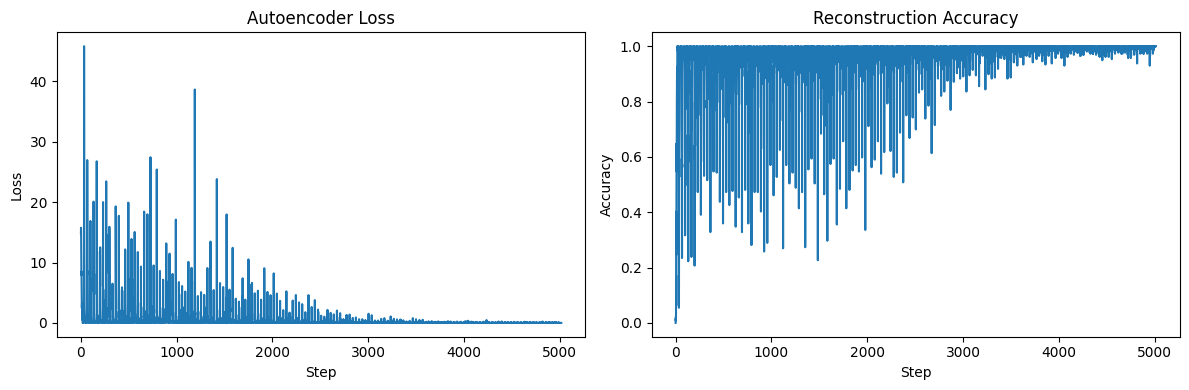


Autoencoder Final Accuracy: 1.0000
KL Loss: 2.6768

Phase 2: Training CALM Model


Training CALM:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Cell 12: Run Everything
if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # Run the main training pipeline
    autoencoder, calm_model = main()

    # Save final models
    torch.save(autoencoder.state_dict(), '/content/autoencoder_final.pt')
    torch.save(calm_model.state_dict(), '/content/calm_model_final.pt')

    print("\nModels saved to /content/")